# Generalized Linear Model
Phần code dưới đây mô tả rõ hơn những ví dụ minh họa được đề cập trong bài báo cáo. Có 3 dataset sẽ được đề cập ở đây là: `students`, `DoctorVisits`, `crab`.

In [81]:
# Import thư viện
!pip uninstall scikit-learn -y
!pip install -U scikit-learn
import sklearn
import scipy
import numpy as np
from matplotlib import pyplot
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

Found existing installation: scikit-learn 0.24.2
Uninstalling scikit-learn-0.24.2:
  Successfully uninstalled scikit-learn-0.24.2
  Using cached scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)


In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_poisson_deviance

## Phần 1. Bộ dữ liệu `students`
Nguồn: https://github.com/bioinformatics-core-shared-training/linear-models-r/blob/master/data/students.csv

Bộ dữ liệu `students` mô tả số học sinh dương tính với một loại truyền nhiễm tính theo từng ngày kể từ khi bùng phát dịch. Dataset này gồm 2 thông số là `day` và `cases` lần lượt mô tả ngày được ghi nhận và số ca dương tính tại thời điểm đó.

In [83]:
student_data = pd.read_csv('https://raw.githubusercontent.com/bioinformatics-core-shared-training/linear-models-r/master/data/students.csv')
student_data.head()

,day,cases
0,1,6
1,2,8
2,3,12
3,3,9
4,4,3


In [84]:
student_X, student_y = np.array(student_data['day']), np.array(student_data['cases'])

In [85]:
student_train_X = sm.add_constant(student_X)

In [86]:
student_model_LR = LinearRegression().fit(student_train_X, student_y)

In [87]:
student_model_GLM = sm.GLM(student_y, student_train_X, family=sm.families.Poisson()).fit()

In [88]:
LR_y, GLM_y = student_model_LR.predict(student_train_X), student_model_GLM.predict(student_train_X)

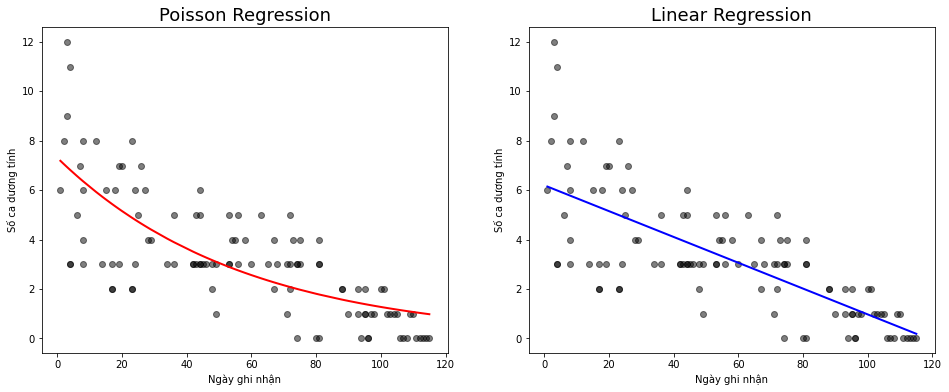

In [89]:
fig, ax = pyplot.subplots(1, 2, figsize=(16, 6))
pyplot.sca(ax[0])
pyplot.title('Poisson Regression', fontsize=18)
pyplot.xlabel('Ngày ghi nhận')
pyplot.ylabel('Số ca dương tính')
ax[0].plot(student_X, GLM_y, color='r', linewidth=2)
ax[0].scatter(student_data['day'], student_data['cases'], color='black', alpha=0.5)

pyplot.sca(ax[1])
pyplot.title('Linear Regression', fontsize=18)
pyplot.xlabel('Ngày ghi nhận')
pyplot.ylabel('Số ca dương tính')
ax[1].plot(student_X, LR_y, color='b', linewidth=2)
ax[1].scatter(student_data['day'], student_data['cases'], color='black', alpha=0.5)

## Phần 2. Bộ dữ liệu `DoctorVisits`
Nguồn: https://vincentarelbundock.github.io/Rdatasets/doc/AER/DoctorVisits.html

Bộ dữ liệu `DoctorVisits` mô tả các thông số về tuổi tác (`age`), bệnh lý (`illness`), năng suấthoạt động (`reduced`),... Ta cần dự đoán số lần đi khám bác sĩ trong 2 tuần vừa qua của mỗi đối tượng.

### Tiền xử lý dữ liệu

In [90]:
doctor_data = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/AER/DoctorVisits.csv',index_col=0)
doctor_data.head()

,visits,gender,age,income,illness,reduced,health,private,freepoor,freerepat,nchronic,lchronic
1,1,female,0.19,0.55,1,4,1,yes,no,no,no,no
2,1,female,0.19,0.45,1,2,1,yes,no,no,no,no
3,1,male,0.19,0.90,3,0,0,no,no,no,no,no
4,1,male,0.19,0.15,1,0,0,no,no,no,no,no
5,1,male,0.19,0.45,2,5,1,no,no,no,yes,no


In [91]:
doctor_data['gender'] = (doctor_data['gender'] == 'female').astype(int)
for val in ['private', 'freepoor', 'freerepat', 'nchronic', 'lchronic']: doctor_data[val] = (doctor_data[val] == 'yes').astype(int)
doctor_data.head()

,visits,gender,age,income,illness,reduced,health,private,freepoor,freerepat,nchronic,lchronic
1,1,1,0.19,0.55,1,4,1,1,0,0,0,0
2,1,1,0.19,0.45,1,2,1,1,0,0,0,0
3,1,0,0.19,0.90,3,0,0,0,0,0,0,0
4,1,0,0.19,0.15,1,0,0,0,0,0,0,0
5,1,0,0.19,0.45,2,5,1,0,0,0,1,0


In [92]:
doctor_data.describe()

,visits,gender,age,income,illness,reduced,health,private,freepoor,freerepat,nchronic,lchronic
count,5190.000000,5190.000000,5190.000000,5190.000000,5190.000000,5190.000000,5190.000000,5190.000000,5190.000000,5190.000000,5190.000000,5190.000000
mean,0.301734,0.520617,0.406385,0.583160,1.431985,0.861850,1.217534,0.442775,0.042775,0.210212,0.403083,0.116570
std,0.798134,0.499623,0.204782,0.368907,1.384152,2.887628,2.124266,0.496762,0.202368,0.407498,0.490564,0.320939
min,0.000000,0.000000,0.190000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.220000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.320000,0.550000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.620000,0.900000,2.000000,0.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,9.000000,1.000000,0.720000,1.500000,5.000000,14.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000


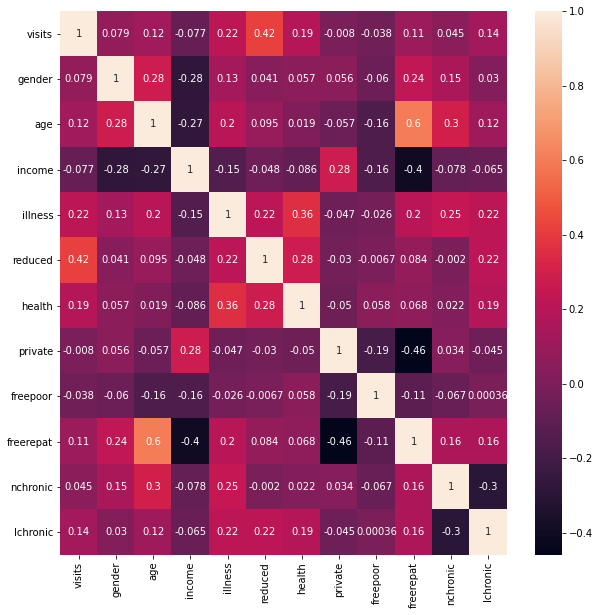

In [93]:
cor = doctor_data.iloc[:,:].corr()

pyplot.figure(figsize=(10, 10))
sns.heatmap(cor, annot=True)

Để tăng độ chính xác của model và hạn chế overfitting, ta áp dụng Feature Selection để sàng lọc và lựa chọn những feature có tương quan lớn nhất so với `visits`. Những feature nào có trị tuyệt đối correlation lớn hơn 0.1 được lựa chọn để cài đặt vào model GLM.

In [94]:
doctor_X = doctor_data.loc[:,['age', 'illness', 'reduced', 'health', 'freerepat', 'lchronic']]
doctor_y = doctor_data.loc[:, 'visits']

Tại đây, ta sử dụng hàm `train_test_split` để chia data thành một phần để fit mô hình và một phần để đánh giá.

In [95]:
doctor_train_X, doctor_test_X, doctor_train_y, doctor_test_y = train_test_split(doctor_X, doctor_y, random_state = 0)

### Cài đặt mô hình
Tại đây, ta cài đặt 3 mô hình Linear Regression, Poisson Regressor (scikit-learn), Generalized Linear Model (statsmodels) trên dữ liệu ta có và so sánh kết quả thu được từ các mô hình này.

In [96]:
doctor_model_LR = LinearRegression().fit(doctor_train_X, doctor_train_y)
doctor_prediction_LR = doctor_model_LR.predict(doctor_test_X)

In [97]:
doctor_model_PR = PoissonRegressor(max_iter=1000).fit(doctor_train_X, doctor_train_y)
doctor_prediction_PR = doctor_model_LR.predict(doctor_test_X)

In [98]:
sm_doctor_train_X, sm_doctor_test_X = sm.add_constant(doctor_train_X), sm.add_constant(doctor_test_X)

In [99]:
doctor_model_GLM = sm.GLM(doctor_train_y, sm_doctor_train_X, family=sm.families.Poisson()).fit()
doctor_prediction_GLM = doctor_model_GLM.predict(sm_doctor_test_X)

### Đánh giá mô hình
Để đánh giá mô hình, ta sử dụng công thức tính độ lệch dưới đây:
$$D = 2 \displaystyle \sum_{n}\;\bigg[y_n\log\bigg(\dfrac{y_n}{\mu_n}\bigg) - (y_n - \mu_n)\bigg]$$
Công thức này đã được cài đặt trong hàm `mean_poisson_deviance` có trong thư viện `scikit-learn`.


In [100]:
scoring = pd.DataFrame(columns=('Model', 'Mean Poisson Deviance'))

LR_score = {
    'Model': 'Linear Regression (scikit-learn)',
    'Mean Poisson Deviance': mean_poisson_deviance(doctor_test_y, doctor_prediction_LR),
}

scoring = scoring.append([LR_score], ignore_index=True)

PR_score = {
    'Model': 'Poisson Regression (scikit-learn)',
    'Mean Poisson Deviance': mean_poisson_deviance(doctor_test_y, doctor_prediction_PR),
}

scoring = scoring.append([PR_score], ignore_index=True)

GLM_score = {
    'Model': 'GLM - Poisson (statsmodels)',
    'Mean Poisson Deviance': mean_poisson_deviance(doctor_test_y, doctor_prediction_GLM),
}

scoring = scoring.append([GLM_score], ignore_index=True)

In [101]:
scoring

,Model,Mean Poisson Deviance
0,Linear Regression (scikit-learn),0.824381
1,Poisson Regression (scikit-learn),0.824381
2,GLM - Poisson (statsmodels),0.879162


## Phần 3. Bộ dữ liệu `crab`
Nguồn: https://github.com/bioinformatics-core-shared-training/linear-models-r/blob/master/data/crab.csv

Bộ dữ liệu `crab` được xây dựng để tìm những đặc tính ảnh hưởng đến số lượng sam đực bám vào cặp sam trong quá trình giao phối. Một số đặc tính được đề cập trong bộ dữ liệu gồm: màu của sam (C), tình trạng đuôi gai (S), chiều dài mai (W) và khối lượng (Wt). Ta áp dụng những biện pháp tương tự ở phần 2.

### Tiền xử lý dữ liệu

In [102]:
crab_data = pd.read_csv('https://raw.githubusercontent.com/bioinformatics-core-shared-training/linear-models-r/master/data/crab.csv',index_col=0)
crab_data.head()

,C,S,W,Wt,Sa
Obs,,,,,
1,2,3,28.3,3.05,8
2,3,3,26.0,2.60,4
3,3,3,25.6,2.15,0
4,4,2,21.0,1.85,0
5,2,3,29.0,3.00,1


In [103]:
crab_data.describe()

,C,S,W,Wt,Sa
count,173.000000,173.000000,173.000000,173.000000,173.000000
mean,2.439306,2.485549,26.298844,2.437225,2.919075
std,0.801933,0.825516,2.109061,0.577255,3.148336
min,1.000000,1.000000,21.000000,1.200000,0.000000
25%,2.000000,2.000000,24.900000,2.000000,0.000000
50%,2.000000,3.000000,26.100000,2.350000,2.000000
75%,3.000000,3.000000,27.700000,2.850000,5.000000
max,4.000000,3.000000,33.500000,5.200000,15.000000


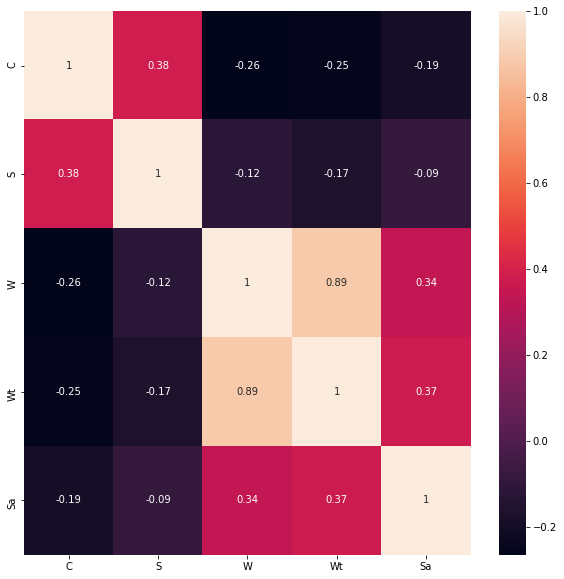

In [104]:
cor = crab_data.iloc[:,:].corr()

pyplot.figure(figsize=(10, 10))
sns.heatmap(cor, annot=True)

In [105]:
crab_X = crab_data.loc[:,['W', 'Wt']]
crab_y = crab_data.loc[:, 'Sa']

In [106]:
crab_train_X, crab_test_X, crab_train_y, crab_test_y = train_test_split(crab_X, crab_y, random_state = 0)

### Cài đặt mô hình

In [107]:
crab_model_LR = LinearRegression().fit(crab_train_X, crab_train_y)
crab_prediction_LR = crab_model_LR.predict(crab_test_X)

In [108]:
crab_model_PR = PoissonRegressor(max_iter=1000).fit(crab_train_X, crab_train_y)
crab_prediction_PR = crab_model_LR.predict(crab_test_X)

In [109]:
sm_crab_train_X, sm_crab_test_X = sm.add_constant(crab_train_X), sm.add_constant(crab_test_X)

In [110]:
crab_model_GLM = sm.GLM(crab_train_y, sm_crab_train_X, family=sm.families.Poisson()).fit()
crab_prediction_GLM = crab_model_GLM.predict(sm_crab_test_X)

### Đánh giá mô hình


In [111]:
scoring = pd.DataFrame(columns=('Model', 'Mean Poisson Deviance'))

LR_score = {
    'Model': 'Linear Regression (scikit-learn)',
    'Mean Poisson Deviance': mean_poisson_deviance(crab_test_y, crab_prediction_LR),
}

scoring = scoring.append([LR_score], ignore_index=True)

PR_score = {
    'Model': 'Poisson Regression (scikit-learn)',
    'Mean Poisson Deviance': mean_poisson_deviance(crab_test_y, crab_prediction_PR),
}

scoring = scoring.append([PR_score], ignore_index=True)

GLM_score = {
    'Model': 'GLM - Poisson (statsmodels)',
    'Mean Poisson Deviance': mean_poisson_deviance(crab_test_y, crab_prediction_GLM),
}

scoring = scoring.append([GLM_score], ignore_index=True)

In [112]:
scoring

,Model,Mean Poisson Deviance
0,Linear Regression (scikit-learn),3.100807
1,Poisson Regression (scikit-learn),3.100807
2,GLM - Poisson (statsmodels),3.114424
